## Imports

### Install packages

In [1]:
!sudo /bin/bash -c "(source /venv/bin/activate; pip install --quiet jupyterlab-vim)"
!jupyter labextension enable

In [2]:
!sudo /bin/bash -c "(source /venv/bin/activate; pip install --quiet graphviz)"

In [3]:
!sudo /bin/bash -c "(source /venv/bin/activate; pip install --quiet dataframe_image)"

### Import modules

In [4]:
%load_ext autoreload
%autoreload 2

import logging

import arviz as az
import pandas as pd
import xarray as xr
import pymc as pm
import numpy as np
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
import preliz as pz

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [5]:
dir_name = "./Lesson07-data"

!ls $dir_name

anscombe.csv	     chemical_shifts_theo_exp.csv  islands.csv
anscombe_3.csv	     coal.csv			   penguins.csv
babies.csv	     dummy.csv			   pigs.csv
bikes.csv	     fish.csv			   redwood.csv
bikes_full.csv	     football_players.csv	   space_flu.csv
body_fat.csv	     horseshoe_crab.csv		   tips.csv
body_fat_full.csv    howell.csv
chemical_shifts.csv  iris.csv


In [6]:
import msml610_utils as ut

ut.config_notebook()

# Setting notebook style
# Notebook signature
Python 3.12.3
Linux ec1347f4acf5 6.10.14-linuxkit #1 SMP Tue Apr 15 16:00:54 UTC 2025 aarch64 aarch64 aarch64 GNU/Linux
numpy version=1.26.4
pymc version=5.18.2
matplotlib version=3.10.3
arviz version=0.21.0
preliz version=0.19.0


# Group comparison

In [7]:
import pandas as pd
import seaborn as sns
import pprint

In [8]:
tips = pd.read_csv(dir_name + '/tips.csv')
tips

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4
...,...,...,...,...,...,...,...
239,29.03,5.92,Male,No,Sat,Dinner,3
240,27.18,2.00,Female,Yes,Sat,Dinner,2
241,22.67,2.00,Male,Yes,Sat,Dinner,2
242,17.82,1.75,Male,No,Sat,Dinner,2


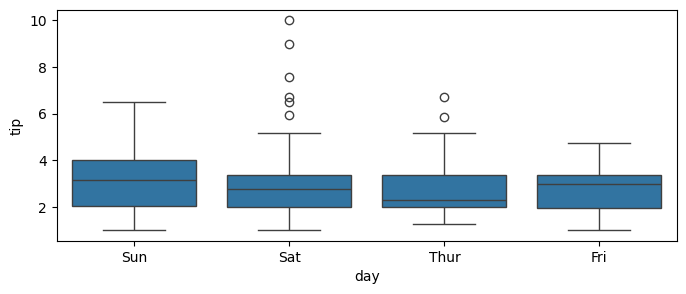

In [9]:
sns.boxplot(x='day', y='tip', data=tips);

In [10]:
# Extract the tips.
tip = tips['tip'].values
print(tip[:10])

# Create a vector going from day to group idx.
idx = pd.Categorical(tips['day']).codes
print("idx=", idx)

# Count the groups.
groups = np.unique(idx)
n_groups = len(groups)
print("groups=", n_groups, groups)

[1.01 1.66 3.5  3.31 3.61 4.71 2.   3.12 1.96 3.23]
idx= [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 3 3 3 3 3 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1
 1 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0
 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3]
groups= 4 [0 1 2 3]


In [11]:
# The model is the same as before but it can be easily vectorized.
# There is no need to write a for-loop.
with pm.Model() as comparing_groups:
    # mu is a vector of 4 elems.
    mu = pm.Normal('mu', mu=0, sigma=10, shape=n_groups)
    # sigma is a vector of 4 elems.
    sigma = pm.HalfNormal("sigma", sigma=10, shape=n_groups)
    # y is a vector of 4 normals each with mean and sigma for the group.
    y = pm.Normal('y', mu=mu[idx], sigma=sigma[idx], observed=tip)
    idata_cg = pm.sample(5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 3 seconds.


# Hierarchical models

In [12]:
cs_data = pd.read_csv(dir_name + '/chemical_shifts_theo_exp.csv')
cs_data["diff"] = cs_data["theo"] - cs_data["exp"]
display(cs_data)

,ID,aa,theo,exp,cat,diff
0,1BM8,ILE,61.18,58.27,Non-Polar,2.91
1,1BM8,TYR,56.95,56.18,Polar,0.77
2,1BM8,SER,56.35,56.84,Polar,-0.49
3,1BM8,ALA,51.96,51.01,Special,0.95
4,1BM8,ARG,56.54,54.64,Charged,1.90
...,...,...,...,...,...,...
1771,1KS9,LYS,55.79,57.51,Charged,-1.72
1772,1KS9,ARG,58.91,59.02,Charged,-0.11
1773,1KS9,LYS,59.49,58.92,Charged,0.57
1774,1KS9,GLU,59.48,58.36,Charged,1.12


In [13]:
diff = cs_data.theo.values - cs_data.exp.values
print("diff=", diff)

# Array of categorical values.
cat_encode = pd.Categorical(cs_data['aa'])
print("cat_encode=", cat_encode)
idx = cat_encode.codes
print("idx=", len(idx), idx)
coords = {"aa": cat_encode.categories}
print("coords=", coords)

diff= [ 2.91  0.77 -0.49 ...  0.57  1.12 -2.48]
cat_encode= ['ILE', 'TYR', 'SER', 'ALA', 'ARG', ..., 'LYS', 'ARG', 'LYS', 'GLU', 'SER']
Length: 1776
Categories (19, object): ['ALA', 'ARG', 'ASN', 'ASP', ..., 'THR', 'TRP', 'TYR', 'VAL']
idx= 1776 [ 8 17 14 ... 10  5 14]
coords= {'aa': Index(['ALA', 'ARG', 'ASN', 'ASP', 'GLN', 'GLU', 'GLY', 'HIS', 'ILE', 'LEU',
       'LYS', 'MET', 'PHE', 'PRO', 'SER', 'THR', 'TRP', 'TYR', 'VAL'],
      dtype='object')}


In [14]:
# Non-hierarchical model.
with pm.Model(coords=coords) as cs_nh:
    # One separate prior for each group.
    mu = pm.Normal('mu', mu=0, sigma=10, dims="aa")
    sigma = pm.HalfNormal("sigma", sigma=10, dims="aa")
    # Likelihood.
    y = pm.Normal("y", mu=mu[idx], sigma=sigma[idx], observed=diff)
    idata_cs_nh = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


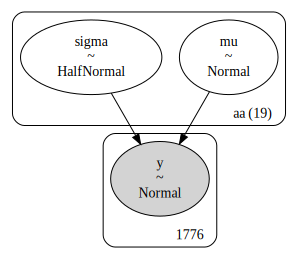

In [15]:
pm.model_to_graphviz(cs_nh)

In [16]:
with pm.Model(coords=coords) as cs_h:
    # Hyper-priors.
    mu_mu = pm.Normal("mu_mu", mu=0, sigma=10)
    mu_sigma = pm.HalfNormal("mu_sigma", sigma=10)
    
    # Priors.
    mu = pm.Normal("mu", mu=mu_mu, sigma=mu_sigma, dims="aa")
    sigma = pm.HalfNormal("sigma", sigma=10, dims="aa")
    
    # Likelihood (same as before).
    y = pm.Normal("y", mu=mu[idx], sigma=sigma[idx], observed=diff)
    idata_cs_h = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_mu, mu_sigma, mu, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


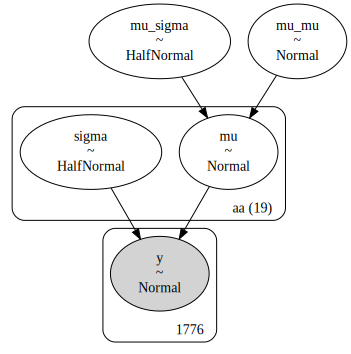

In [17]:
pm.model_to_graphviz(cs_h)

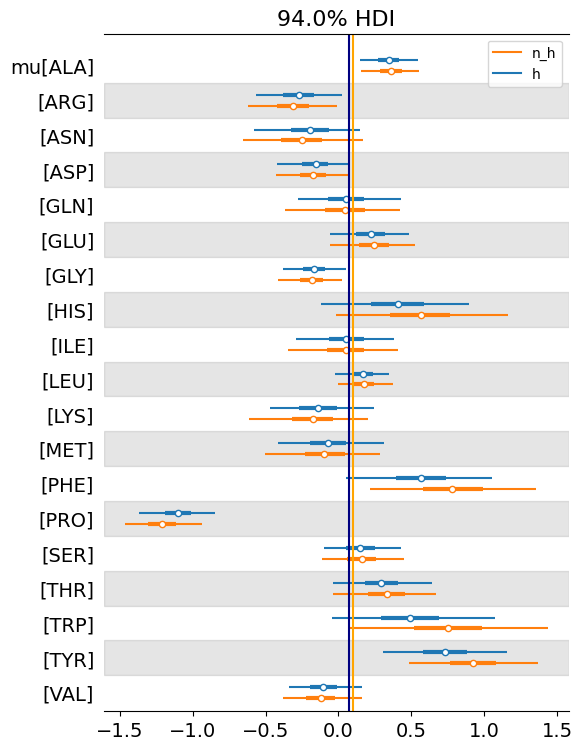

In [18]:
# We have two models and we want to compare the estimates.
# - There are 20 groups and each model has 4 estimates.
# - We plot the 94% credible intervals.
# - The vertical line is the global mean according to the hierarchical model.
# - The blue (hierarchical) means are pulled towards the mean, wrt the orange (non-hierarchical) ones.
axes = az.plot_forest([idata_cs_h, idata_cs_nh],
                      model_names=['h', 'n_h'],
                      var_names='mu',
                      combined=True,
                      colors='cycle')

y_lims = axes[0].get_ylim()
axes[0].vlines(idata_cs_h.posterior['mu_mu'].mean(), *y_lims, color='navy')
axes[0].vlines(idata_cs_nh.posterior['mu'].mean(), *y_lims, color='orange');